In [60]:
import mlflow.xgboost
import mlflow
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, make_scorer
import mlflow.sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from mlflow import lightgbm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:

final_features_regression = [

    # numeric
    "AMT_INCOME_TOTAL",
    "DAYS_BIRTH",
    "DAYS_REGISTRATION",
    "CNT_FAM_MEMBERS",
    "REGION_RATING_CLIENT",
    "REGION_POPULATION_RELATIVE",

    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",

    "Annuity_to_Income_Ratio",

    # POS (light usage signals)
    "pos_mean_cnt_instalment",

    # Previous applications
    "avg_prev_amt_credit",
    "prev_num_approved",

    # Credit card
    "avg_cc_max_limit_used",

    # categorical
    "NAME_CONTRACT_TYPE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",

    #Target
    "AMT_CREDIT"
]

In [3]:

df = pd.read_csv("../data/final/Regression_table.csv")
df=df[final_features_regression]


In [124]:
df.shape

(307511, 22)

In [125]:
df.sample(5)

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_REGISTRATION,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Annuity_to_Income_Ratio,...,prev_num_approved,avg_cc_max_limit_used,NAME_CONTRACT_TYPE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,AMT_CREDIT
55388,198000.0,0.132423,0.074693,2.0,2,0.010276,0.741632,0.003635,0.827703,0.135523,...,2.0,180000.0,Cash loans,Commercial associate,Secondary / secondary special,Married,House / apartment,Managers,Postal,807984.0
297420,112500.0,0.107315,0.010464,3.0,2,0.010966,0.505998,0.418151,0.736623,0.368240,...,1.0,180000.0,Cash loans,Working,Secondary / secondary special,Married,House / apartment,Laborers,Industry: type 9,675000.0
67383,157500.0,0.164534,0.001291,2.0,2,0.010643,0.505998,0.700430,0.535276,0.193343,...,4.0,112500.0,Cash loans,Pensioner,Secondary / secondary special,Married,House / apartment,Unknown,XNA,917451.0
122415,135000.0,0.145889,0.006178,2.0,3,0.018209,0.584623,0.503561,0.502878,0.353400,...,1.0,180000.0,Cash loans,Commercial associate,Secondary / secondary special,Married,House / apartment,Managers,Self-employed,1507500.0
305761,189000.0,0.173286,0.003288,2.0,1,0.072508,0.505998,0.704693,0.353988,0.134119,...,1.0,180000.0,Cash loans,Pensioner,Secondary / secondary special,Married,House / apartment,Unknown,XNA,862560.0


In [126]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH']) / 365
df['DAYS_REGISTRATION'] = abs(df['DAYS_REGISTRATION']) / 365

In [127]:
df['Annuity_to_Income_Ratio'] = df['Annuity_to_Income_Ratio'].clip(
    upper=df['Annuity_to_Income_Ratio'].quantile(0.99),
    axis=0
)

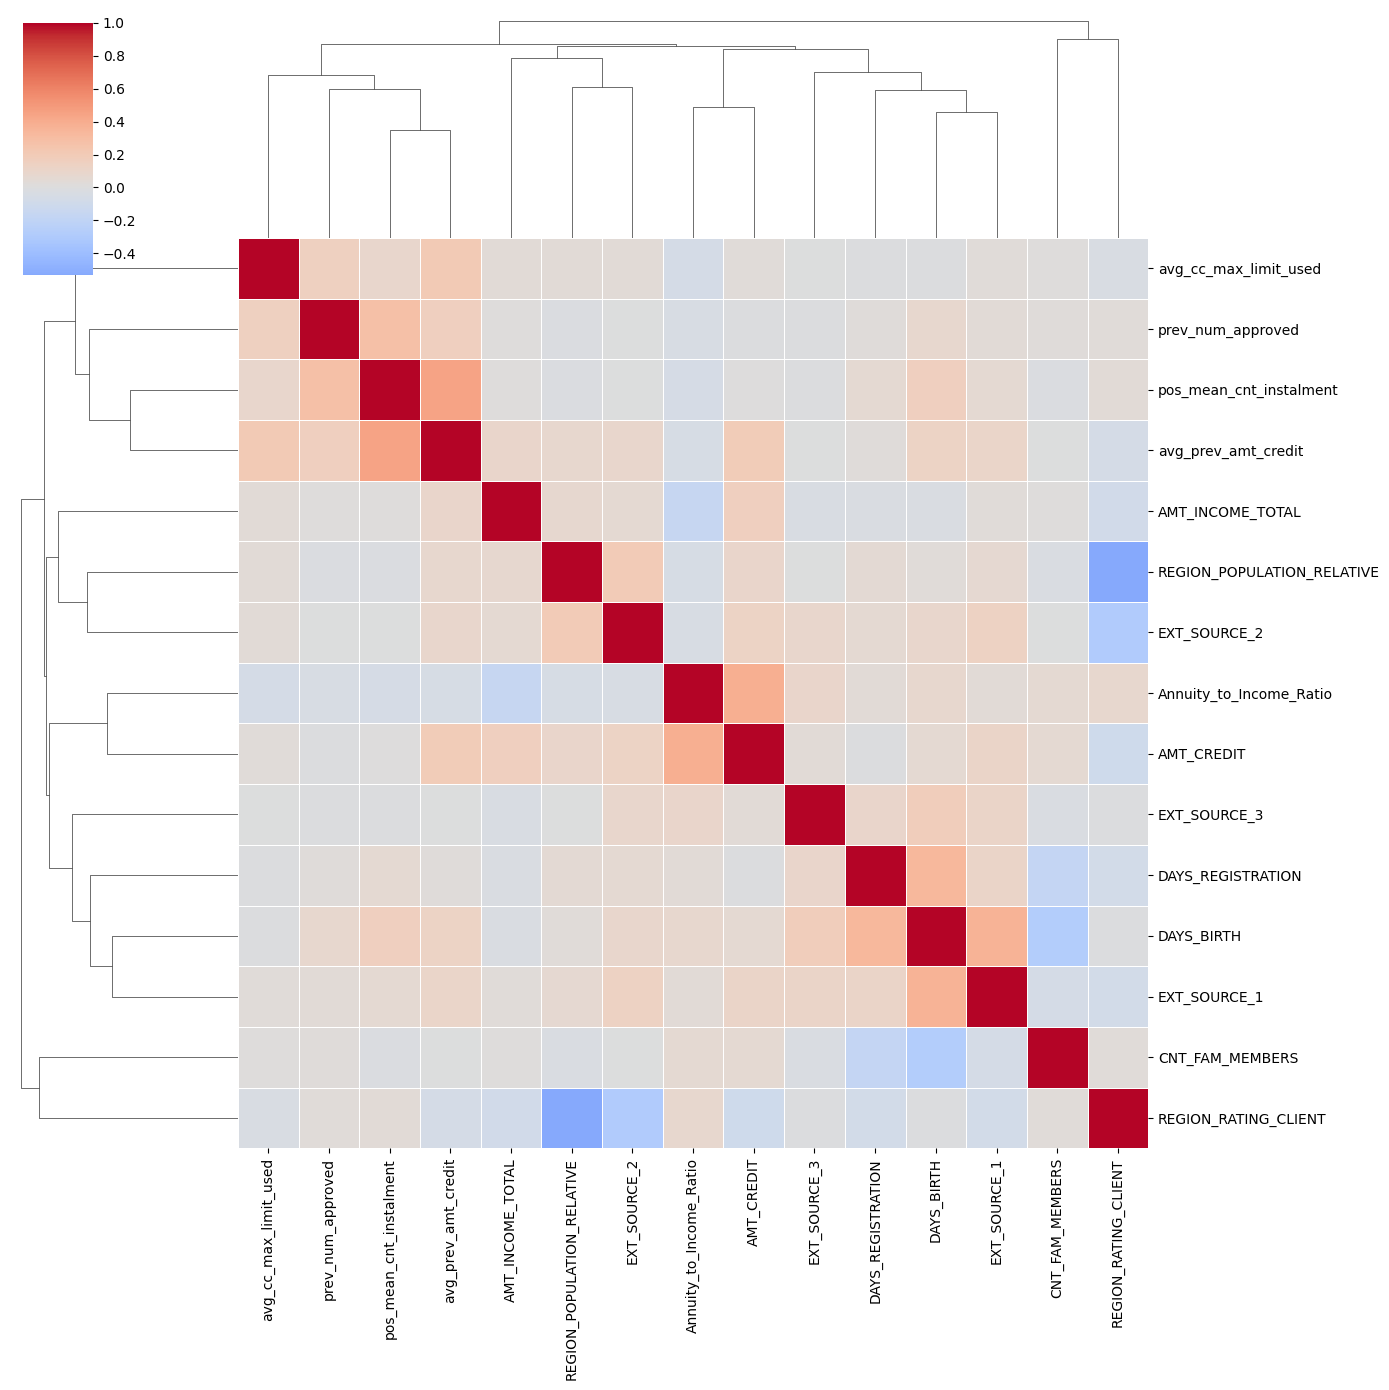

In [128]:
num_df = df[final_features_regression].select_dtypes(include=['int64', 'float64'])

corr = num_df.corr(method='pearson', min_periods=10)  
corr = corr.fillna(0)

sns.clustermap(
    corr,
    cmap='coolwarm',
    center=0,
    figsize=(14, 14),
    linewidths=0.5
)

plt.show()

Linear Regression

In [129]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [130]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        drop=None,
        sparse_output=False
    ))
])

In [131]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ]
)


In [132]:
model1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [133]:
X = df[num_cols + cat_cols]
y = df["AMT_CREDIT"] 

In [134]:
y=np.log1p(y)

In [135]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [137]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    
    model1.fit(X_train, y_train)

    preds = model1.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(preds)) / np.expm1(y_val))) * 100

    mlflow.log_metric("MAPE",mape)
    mlflow.log_metric("RMSE", rmse)


    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("features_count", X.shape[1])

    # Save model
    mlflow.sklearn.log_model(
        model1,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:",mape)

2025/12/21 17:34:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 6.621204464296729e+30
RMSE: 1.8358535661766947e+33
MAPE: 1.1771218498245706e+27
🏃 View run crawling-hen-953 at: http://127.0.0.1:5000/#/experiments/1/runs/620a9d09a3f143b7bb8f54b004a19950
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


XGBRegressor

In [10]:
df_model = df[final_features_regression]

for col in cat_cols:
    df_model[col] = df_model[col].fillna("Unknown")
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

In [ ]:
X = df_model.drop(columns=['AMT_CREDIT'])
y = df["AMT_CREDIT"] 
y=np.log1p(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [49]:
model3= XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1)

In [50]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model3.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
)

    preds = model3.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(preds)) / np.expm1(y_val))) * 100
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "XGBRegressor")
    # Log XGBoost parameters
    for param_name, param_value in model3.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    # Save model
    mlflow.xgboost.log_model(
        model3,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:", mape)


[0]	validation_0-mae:0.55861
[1]	validation_0-mae:0.53552
[2]	validation_0-mae:0.52557
[3]	validation_0-mae:0.50519
[4]	validation_0-mae:0.48642
[5]	validation_0-mae:0.46904
[6]	validation_0-mae:0.45312
[7]	validation_0-mae:0.44587
[8]	validation_0-mae:0.43146
[9]	validation_0-mae:0.41809
[10]	validation_0-mae:0.41241
[11]	validation_0-mae:0.40058
[12]	validation_0-mae:0.38965
[13]	validation_0-mae:0.38518
[14]	validation_0-mae:0.37568
[15]	validation_0-mae:0.36701
[16]	validation_0-mae:0.36401
[17]	validation_0-mae:0.35620
[18]	validation_0-mae:0.35324
[19]	validation_0-mae:0.35052
[20]	validation_0-mae:0.34684
[21]	validation_0-mae:0.34044
[22]	validation_0-mae:0.33448
[23]	validation_0-mae:0.33193
[24]	validation_0-mae:0.32987
[25]	validation_0-mae:0.32502
[26]	validation_0-mae:0.32041
[27]	validation_0-mae:0.31644
[28]	validation_0-mae:0.31268
[29]	validation_0-mae:0.30936
[30]	validation_0-mae:0.30638
[31]	validation_0-mae:0.30352
[32]	validation_0-mae:0.30270
[33]	validation_0-ma

2025/12/21 09:39:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 160439.90402351168
RMSE: 229817.52762295114
MAPE: 29.28197628145137
🏃 View run valuable-crane-874 at: http://127.0.0.1:5000/#/experiments/1/runs/f847534977444d3a8a5682339b16424d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [51]:
print(np.min(y_val), np.max(y_val))
print(np.min(preds), np.max(preds))

10.714439990727769 15.214227685996272
10.71818 14.777356


LightGBM

In [29]:
model4 = LGBMRegressor(
    objective="regression",      
    metric="mae",
    learning_rate=0.06,
    num_leaves=128,
    max_depth=-1,
    n_estimators=800,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
)

In [30]:
loan_sizes = np.expm1(y_train)  
sample_weights = loan_sizes / np.mean(loan_sizes)

In [31]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model4.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    sample_weight=sample_weights
)

    preds = model4.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(preds)) / np.expm1(y_val))) * 100

    mlflow.log_metric("RMSE", rmse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_param("model_type", "LIGHTGBMRegressor")
    for param_name, param_value in model4.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    mlflow.lightgbm.log_model(
        model4,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:", mape)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 21
[LightGBM] [Info] Start training from score 13.513374


2025/12/21 12:36:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 161090.08520448528
RMSE: 226985.08308154132
MAPE: 33.01710158882314
🏃 View run rogue-cub-300 at: http://127.0.0.1:5000/#/experiments/1/runs/4247f99bee4c4012a6ba511cb5bda046
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [40]:
# Segment analysis
preds= predict_segmented(X_val)
loan_sizes = np.expm1(y)  # Your actual loans
errors = np.abs(np.expm1(preds) - np.expm1(y_val))

quartiles = np.percentile(loan_sizes, [25, 50, 75])
print("MAPE by loan size quartile:")
for i, (low, high) in enumerate([(0, quartiles[0]), 
                                  (quartiles[0], quartiles[1]),
                                  (quartiles[1], quartiles[2]),
                                  (quartiles[2], np.inf)]):
    mask = (loan_sizes >= low) & (loan_sizes < high)
    if mask.sum() > 0:
        segment_mape = np.mean(errors[mask] / loan_sizes[mask]) * 100
        print(f"Q{i+1} (${low:,.0f}-${high:,.0f}): {segment_mape:.1f}%")

MAPE by loan size quartile:
Q1 ($0-$270,000): 48.3%
Q2 ($270,000-$513,531): 30.5%
Q3 ($513,531-$808,650): 22.0%
Q4 ($808,650-$inf): 24.3%


In [ ]:

# Cost of errors
average_loan = np.mean(loan_sizes)
print(f"\nBusiness Impact:")
print(f"Average loan: ${average_loan:,.0f}")
print(f"Average error: ${mae:,.0f}")
print(f"Error as % of loan: {mae/average_loan*100:.1f}%")

# For a $10M portfolio:
portfolio_value = 10_000_000
avg_error_rate = mae / average_loan
print(f"\nFor ${portfolio_value:,.0f} portfolio:")
print(f"Expected prediction error: ${portfolio_value * avg_error_rate:,.0f}")


Business Impact:
Average loan: $599,026
Average error: $160,564
Error as % of loan: 26.8%

For $10,000,000 portfolio:
Expected prediction error: $2,680,425


Segmentation model

In [41]:
y_train_real = np.expm1(y_train)
q1, q2 = np.quantile(y_train_real, [0.33, 0.66])

print("Loan thresholds from training data:")
print(f"Small  <= ${q1:,.0f}")
print(f"Medium <= ${q2:,.0f}")
print(f"Large  >  ${q2:,.0f}")

Loan thresholds from training data:
Small  <= $331,920
Medium <= $675,000
Large  >  $675,000


In [ ]:
def assign_segment(y_real, q1, q2):
    return np.where(
        y_real <= q1, "small",
        np.where(y_real <= q2, "medium", "large")
    )

In [ ]:
train_segments = assign_segment(y_train_real, q1, q2)
val_segments = assign_segment(np.expm1(y_val), q1, q2)

In [44]:
segment_models = {}

for segment in ["small", "medium", "large"]:
    idx = train_segments == segment
    X_seg = X_train.loc[idx]
    y_seg = y_train.loc[idx]
    
    print(f"\nTraining {segment} model | samples: {len(X_seg):,} ({len(X_seg)/len(X_train)*100:.1f}%)")
    
    if segment == "small":
        model = LGBMRegressor(
            objective="regression",
            metric="mae",
            learning_rate=0.08,  
            num_leaves=64, 
            max_depth=7,
            n_estimators=600,
            min_child_samples=20,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.05,
            reg_lambda=0.5,
            random_state=42,
        )
    elif segment == "medium":
        model = LGBMRegressor(
            objective="regression",
            metric="mae",
            learning_rate=0.06,
            num_leaves=128,
            max_depth=-1,
            n_estimators=800,
            min_child_samples=30,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
        )
    else: 
        model = LGBMRegressor(
            objective="regression",
            metric="mae",
            learning_rate=0.04,  
            num_leaves=256,  
            max_depth=10,
            n_estimators=1000,
            min_child_samples=50,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=0.2,
            reg_lambda=2.0,
            random_state=42,
        )
    
    model.fit(X_seg, y_seg)
    segment_models[segment] = model
    print(f"  Trained on {segment} loans: ${np.expm1(y_seg).min():,.0f} - ${np.expm1(y_seg).max():,.0f}")


Training small model | samples: 76,215 (33.0%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2481
[LightGBM] [Info] Number of data points in the train set: 76215, number of used features: 21
[LightGBM] [Info] Start training from score 12.239867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [53]:
def predict_segment_from_features(X, q1, q2):
    """
    Predict which segment a loan application belongs to
    based on INPUT FEATURES, not model predictions
    """
    # Use income, requested credit, and other features to predict segment
    # Option 1: Simple rule-based (fastest)
    predicted_small = (
        (X['AMT_INCOME_TOTAL'] < 300_000) 
    ).values
    
    predicted_large = (
        (X['AMT_INCOME_TOTAL'] > 600_000) 
    ).values
    
    predicted_medium = ~(predicted_small | predicted_large)
    
    # Create segment array
    segments = np.full(len(X), "medium", dtype=object)
    segments[predicted_small] = "small"
    segments[predicted_large] = "large"
    
    return segments

In [47]:
from sklearn.ensemble import RandomForestClassifier

def train_segment_classifier(X_train_seg, train_segments):
    """Train a classifier to predict loan segments"""
    segment_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    segment_clf.fit(X_train_seg, train_segments)
    return segment_clf
segment_classifier = train_segment_classifier(X_train, train_segments)

def predict_segment_classifier(X, classifier):
    """Predict segments using trained classifier"""
    return classifier.predict(X)

In [48]:

def true_segmented_predict(X, models, segment_predictor="classifier", classifier=None, q1=None, q2=None):
    preds_log = np.zeros(len(X))
    
    # Decide which segment each sample belongs to
    if segment_predictor == "classifier" and classifier is not None:
        segs = classifier.predict(X)
    elif segment_predictor == "rule" and q1 is not None and q2 is not None:
        segs = predict_segment_from_features(X, q1, q2)
    elif segment_predictor == "actual":
        # Only for validation - uses actual segments
        # Don't use in production!
        segs = assign_segment(np.expm1(y_val), q1, q2)
    else:
        raise ValueError("Invalid segment_predictor or missing parameters")
    
    unique_segs, counts = np.unique(segs, return_counts=True)
    print(f"\nSegment distribution in prediction set:")
    for seg, count in zip(unique_segs, counts):
        print(f"  {seg}: {count:,} samples ({count/len(X)*100:.1f}%)")
    
    # Predict using appropriate model
    for segment in ["small", "medium", "large"]:
        idx = segs == segment
        if idx.sum() > 0:
            preds_log[idx] = models[segment].predict(X.loc[idx])
    
    return preds_log, segs

In [49]:
preds_log_classifier, pred_segments_classifier = true_segmented_predict(
    X_val, segment_models, segment_predictor="classifier", classifier=segment_classifier
)


Segment distribution in prediction set:
  large: 28,289 samples (36.8%)
  medium: 25,751 samples (33.5%)
  small: 22,838 samples (29.7%)


In [50]:
def calculate_metrics(preds_log, y_true, label=""):
    """Calculate and print evaluation metrics"""
    preds_real = np.expm1(preds_log)
    y_real = np.expm1(y_true)
    
    mae = np.mean(np.abs(preds_real - y_real))
    rmse = np.sqrt(np.mean((preds_real - y_real) ** 2))
    mape = np.mean(np.abs((y_real - preds_real) / y_real)) * 100
    
    print(f"\n{label} Results:")
    print(f"MAE: ${mae:,.0f}")
    print(f"RMSE: ${rmse:,.0f}")
    print(f"MAPE: {mape:.1f}%")
    
    return mae, rmse, mape

In [51]:
mae_clf, rmse_clf, mape_clf = calculate_metrics(preds_log_classifier, y_val, "Classifier-based segmentation")


Classifier-based segmentation Results:
MAE: $170,918
RMSE: $245,566
MAPE: 33.6%


In [54]:
preds_log_rule, pred_segments_rule = true_segmented_predict(
    X_val, segment_models, segment_predictor="rule", q1=q1, q2=q2
)

# Method 3: Using actual segments (for comparison only - not production)
preds_log_actual, pred_segments_actual = true_segmented_predict(
    X_val, segment_models, segment_predictor="actual", q1=q1, q2=q2
)


Segment distribution in prediction set:
  large: 378 samples (0.5%)
  medium: 5,228 samples (6.8%)
  small: 71,272 samples (92.7%)

Segment distribution in prediction set:
  large: 25,687 samples (33.4%)
  medium: 25,905 samples (33.7%)
  small: 25,286 samples (32.9%)


In [55]:
mae_rule, rmse_rule, mape_rule = calculate_metrics(preds_log_rule, y_val, "Rule-based segmentation")
mae_actual, rmse_actual, mape_actual = calculate_metrics(preds_log_actual, y_val, "Ideal (actual segment)")



Rule-based segmentation Results:
MAE: $324,190
RMSE: $468,077
MAPE: 42.7%

Ideal (actual segment) Results:
MAE: $94,697
RMSE: $155,909
MAPE: 16.1%


In [56]:
for segment in ["small", "medium", "large"]:
    # Actual segments from validation data
    idx = val_segments == segment
    
    if idx.sum() > 0:
        mae_seg = np.mean(np.abs(np.expm1(preds_log_classifier[idx]) - np.expm1(y_val[idx])))
        mape_seg = np.mean(np.abs((np.expm1(y_val[idx]) - np.expm1(preds_log_classifier[idx])) / np.expm1(y_val[idx]))) * 100
        
        # How well did we predict the segment?
        pred_this_segment = pred_segments_classifier[idx]
        segment_accuracy = np.mean(pred_this_segment == segment) * 100
        
        print(f"\n{segment.upper()} Loans:")
        print(f"  Samples: {idx.sum():,}")
        print(f"  Actual MAE: ${mae_seg:,.0f}")
        print(f"  Actual MAPE: {mape_seg:.1f}%")
        print(f"  Segment prediction accuracy: {segment_accuracy:.1f}%")



SMALL Loans:
  Samples: 25,286
  Actual MAE: $92,176
  Actual MAPE: 40.7%
  Segment prediction accuracy: 76.8%

MEDIUM Loans:
  Samples: 25,905
  Actual MAE: $187,048
  Actual MAPE: 37.5%
  Segment prediction accuracy: 59.5%

LARGE Loans:
  Samples: 25,687
  Actual MAE: $232,164
  Actual MAPE: 22.6%
  Segment prediction accuracy: 79.6%


Register model

In [16]:
run_id="9e2f89bdda644ba3a237cadedeb0ceb6"
model_uri = f"runs:/{run_id}/model"

mlflow.register_model(
    model_uri=model_uri,
    name="LightGBM_Loan_Amount_Predictor"
)


Successfully registered model 'LightGBM_Loan_Amount_Predictor'.
2025/12/18 13:44:44 WARNING mlflow.tracking._model_registry.fluent: Run with id 9e2f89bdda644ba3a237cadedeb0ceb6 has no artifacts at artifact path 'model', registering model based on models:/m-f0201efc83ef47adac5e7f2f4d817ebb instead
2025/12/18 13:44:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_Loan_Amount_Predictor, version 1
Created version '1' of model 'LightGBM_Loan_Amount_Predictor'.


<ModelVersion: aliases=[], creation_timestamp=1766045684954, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1766045684954, metrics=None, model_id=None, name='LightGBM_Loan_Amount_Predictor', params=None, run_id='9e2f89bdda644ba3a237cadedeb0ceb6', run_link='', source='models:/m-f0201efc83ef47adac5e7f2f4d817ebb', status='READY', status_message=None, tags={}, user_id='', version='1'>

GridSearchCV on LightGBM

In [11]:
def real_mae(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return mean_absolute_error(y_true, y_pred)

mae_scorer = make_scorer(real_mae, greater_is_better=False)

In [12]:
lgb_model = LGBMRegressor(
    objective="regression",
    random_state=42,
    n_jobs=-1
)

In [13]:
param_grid = {
    "learning_rate": [0.03, 0.05],
    "num_leaves": [31, 63],
    "max_depth": [-1, 6],
    "n_estimators": [500, 800],
    "min_child_samples": [20, 40],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y) 

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 264909, number of used features: 22
[LightGBM] [Info] Start training from score 13.085680


,estimator,LGBMRegressor...ndom_state=42)
,param_grid,"{'colsample_bytree': [0.8], 'learning_rate': [0.03, 0.05], 'max_depth': [-1, 6], 'min_child_samples': [20, 40], ...}"
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [16]:
best_model = grid_search.best_estimator_
para=best_model.get_params()
best_model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2732
[LightGBM] [Info] Number of data points in the train set: 264909, number of used features: 22
[LightGBM] [Info] Start training from score 13.085680


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,800
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,40


In [17]:
model5 = LGBMRegressor(
        **para
    )

In [18]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model5.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)]
)

    preds = model5.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mlflow.log_metric("RMSE", rmse)


    mlflow.log_metric("MAE", mae)
    mlflow.log_param("model_type", "LIGHTGBMRegressor_best")
    for param_name, param_value in model5.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    mlflow.lightgbm.log_model(
        model5,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)


2025/12/17 18:09:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/17 18:09:07 INFO mlflow.store.db.utils: Updating database tables
2025/12/17 18:09:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:09:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 18:09:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:09:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2743
[LightGBM] [Info] Number of data points in the train set: 198681, number of used features: 22
[LightGBM] [Info] Start training from score 13.085030


2025/12/17 18:09:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 6212.302837843538
RMSE: 18939.651184803264
🏃 View run stately-slug-408 at: http://127.0.0.1:5000/#/experiments/1/runs/87c61d39c7ba4faa820b6ffc4a7b5d14
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Cross Validation

In [21]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LGBMRegressor(
        **para
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mae"
    )

    y_pred = model.predict(X_val)
    fold_mae = mean_absolute_error(
        np.expm1(y_val), np.expm1(y_pred)
    )

    mae_scores.append(fold_mae)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.084887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2741
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.085869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train

In [22]:
for fold, score in enumerate(mae_scores):
    print(f"Fold {fold+1} MAE: {score:.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")

Fold 1 MAE: 6233.87
Fold 2 MAE: 6237.17
Fold 3 MAE: 6175.65
Fold 4 MAE: 6096.15
Fold 5 MAE: 6322.72
Fold 6 MAE: 6068.00
Average MAE: 6188.93
Standard Deviation of MAE: 87.23147708003332


In [23]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    model4.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mae"
    )

    y_pred = model4.predict(X_val)
    fold_mae = mean_absolute_error(
        np.expm1(y_val), np.expm1(y_pred)
    )

    mae_scores.append(fold_mae)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.084887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2741
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Start training from score 13.085869
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2740
[LightGBM] [Info] Number of data points in the train set: 220757, number of used features: 22
[LightGBM] [Info] Star

In [24]:
for fold, score in enumerate(mae_scores):
    print(f"Fold {fold+1} MAE: {score:.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")

Fold 1 MAE: 5899.77
Fold 2 MAE: 5830.16
Fold 3 MAE: 5864.63
Fold 4 MAE: 5741.04
Fold 5 MAE: 5950.08
Fold 6 MAE: 5883.63
Average MAE: 5861.55
Standard Deviation of MAE: 64.94301951548468


In [27]:
# normal training
model4.fit(X_train, y_train)

preds = model4.predict(X_val)

mae_normal = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
print("Normal MAE:", mae_normal)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 220758, number of used features: 22
[LightGBM] [Info] Start training from score 13.086784
Normal MAE: 5883.633562598447


In [28]:
y_train_shuffled = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

model4.fit(X_train, y_train_shuffled)

preds_shuffled = model4.predict(X_val)

mae_shuffled = np.mean(np.abs(np.expm1(preds_shuffled) - np.expm1(y_val)))
print("Shuffled-target MAE:", mae_shuffled)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2744
[LightGBM] [Info] Number of data points in the train set: 220758, number of used features: 22
[LightGBM] [Info] Start training from score 13.086784
Shuffled-target MAE: 311888.17923640774


SHAP explanations

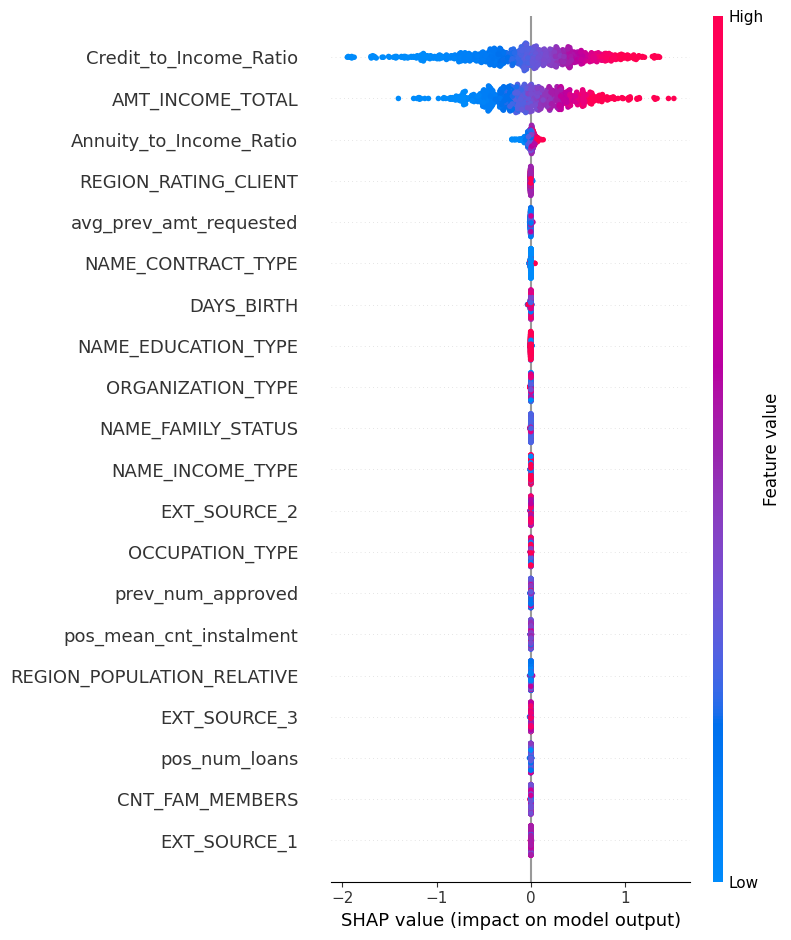

In [17]:
X_shap = X_val.sample(1000, random_state=42)
explainer = shap.TreeExplainer(model4)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)

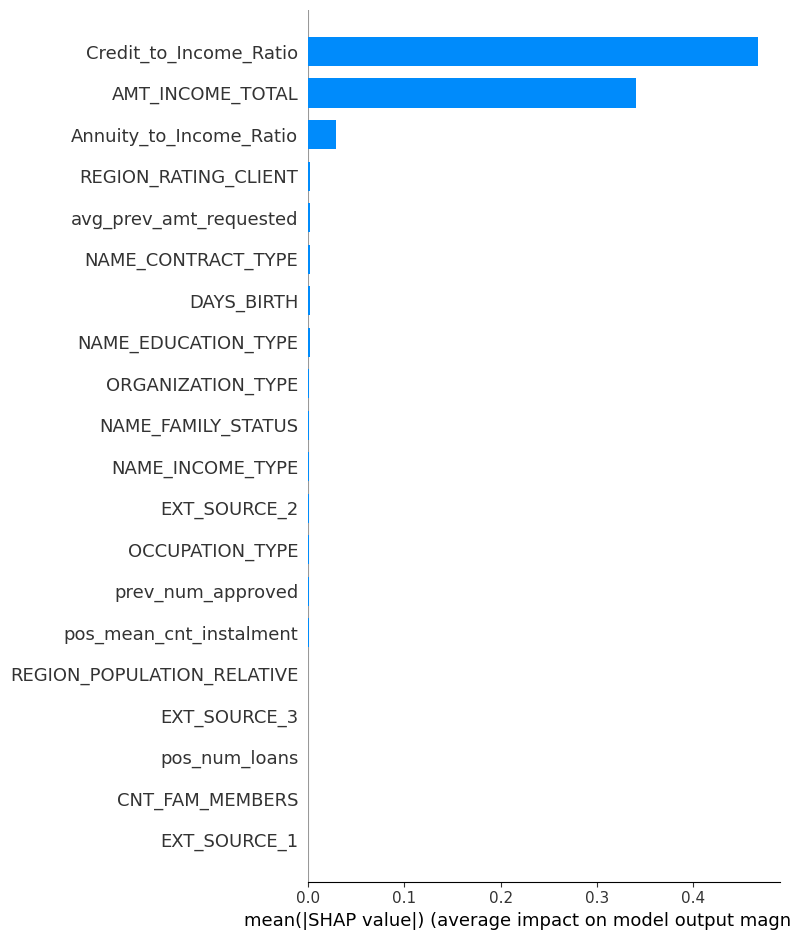

In [18]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

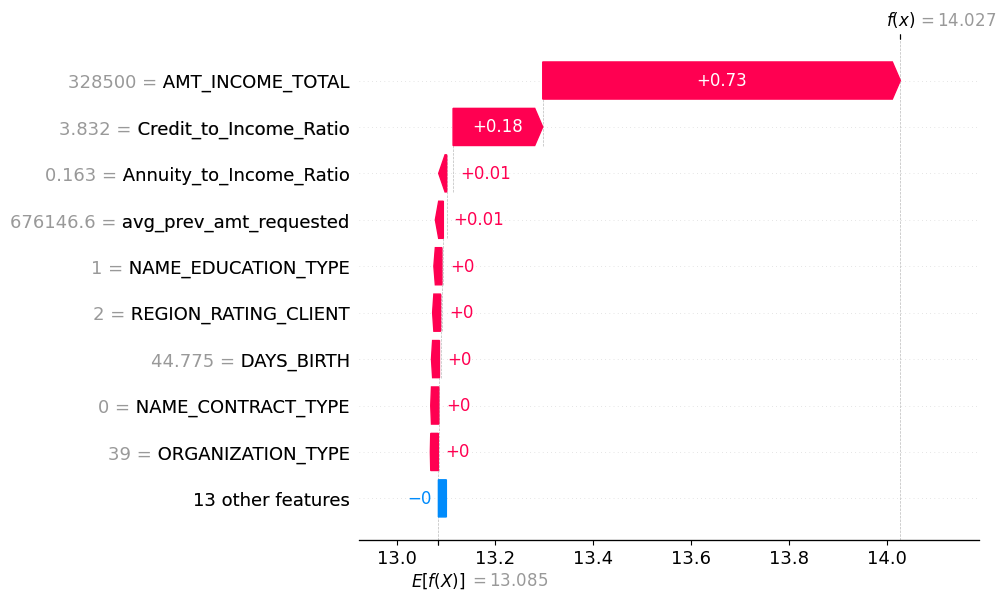

In [22]:
i =901
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_shap.iloc[i],
        feature_names=X_shap.columns
    )
)


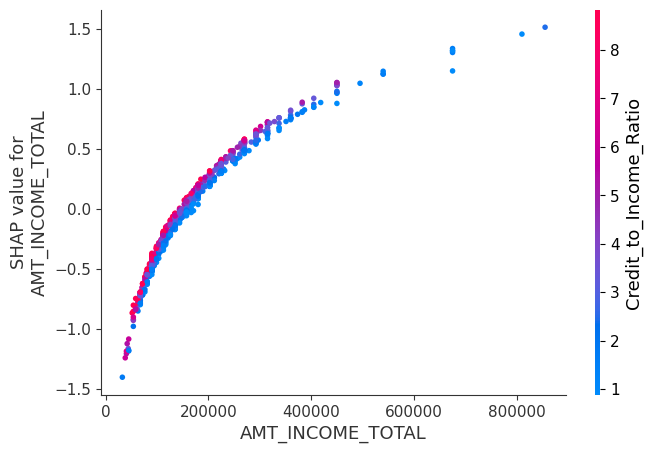

In [23]:
shap.dependence_plot(
    "AMT_INCOME_TOTAL",
    shap_values,
    X_shap
)

FINAL MODEL

In [140]:
df_model = df[final_features_regression]

for col in cat_cols:
    df_model[col] = df_model[col].fillna("Unknown")
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

In [141]:
X = df_model.drop(columns=['AMT_CREDIT'])
y = df["AMT_CREDIT"] 

In [142]:
y=np.log1p(y)

In [143]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [152]:
model4 = LGBMRegressor(
    objective="regression",      
    metric="mae",
    learning_rate=0.06,
    num_leaves=128,
    max_depth=-1,
    n_estimators=850,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
)

In [153]:
mlflow.set_experiment("loan_amount_regression")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model4.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
)

    preds = model4.predict(X_val)

    mae = np.mean(np.abs(np.expm1(preds) - np.expm1(y_val)))
    rmse = np.sqrt(np.mean((np.expm1(preds) - np.expm1(y_val)) ** 2))
    mape = np.mean(np.abs((np.expm1(y_val) - np.expm1(preds)) / np.expm1(y_val))) * 100

    mlflow.log_metric("RMSE", rmse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_param("model_type", "LIGHTGBMRegressor")
    for param_name, param_value in model4.get_params().items():
        if param_value is not None:
            mlflow.log_param(param_name, param_value)

    mlflow.log_param("features_count", X.shape[1])

    mlflow.lightgbm.log_model(
        model4,
        artifact_path="model"
    )

    print("MAE:", mae)
    print("RMSE:", rmse)
    print("MAPE:", mape)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 21
[LightGBM] [Info] Start training from score 13.070688


2025/12/21 17:44:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MAE: 160578.80495478568
RMSE: 230012.38572643767
MAPE: 29.35228094684847
🏃 View run exultant-stoat-638 at: http://127.0.0.1:5000/#/experiments/1/runs/9f735423a53a402883f015c4417ae1c7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [122]:
# Segment analysis
loan_sizes = np.expm1(y)  
errors = np.abs(np.expm1(preds) - np.expm1(y_val))

quartiles = np.percentile(loan_sizes, [25, 50, 75])
print("MAPE by loan size quartile:")
for i, (low, high) in enumerate([(0, quartiles[0]), 
                                  (quartiles[0], quartiles[1]),
                                  (quartiles[1], quartiles[2]),
                                  (quartiles[2], np.inf)]):
    mask = (loan_sizes >= low) & (loan_sizes < high)
    if mask.sum() > 0:
        segment_mape = np.mean(errors[mask] / loan_sizes[mask]) * 100
        print(f"Q{i+1} (${low:,.0f}-${high:,.0f}): {segment_mape:.1f}%")

MAPE by loan size quartile:
Q1 ($0-$270,000): 40.0%
Q2 ($270,000-$513,531): 30.4%
Q3 ($513,531-$808,650): 23.3%
Q4 ($808,650-$inf): 24.4%


In [123]:
# Cost of errors
average_loan = np.mean(loan_sizes)
print(f"\nBusiness Impact:")
print(f"Average loan: ${average_loan:,.0f}")
print(f"Average error: ${mae:,.0f}")
print(f"Error as % of loan: {mae/average_loan*100:.1f}%")

# For a $10M portfolio:
portfolio_value = 10_000_000
avg_error_rate = mae / average_loan
print(f"\nFor ${portfolio_value:,.0f} portfolio:")
print(f"Expected prediction error: ${portfolio_value * avg_error_rate:,.0f}")


Business Impact:
Average loan: $599,026
Average error: $160,564
Error as % of loan: 26.8%

For $10,000,000 portfolio:
Expected prediction error: $2,680,425


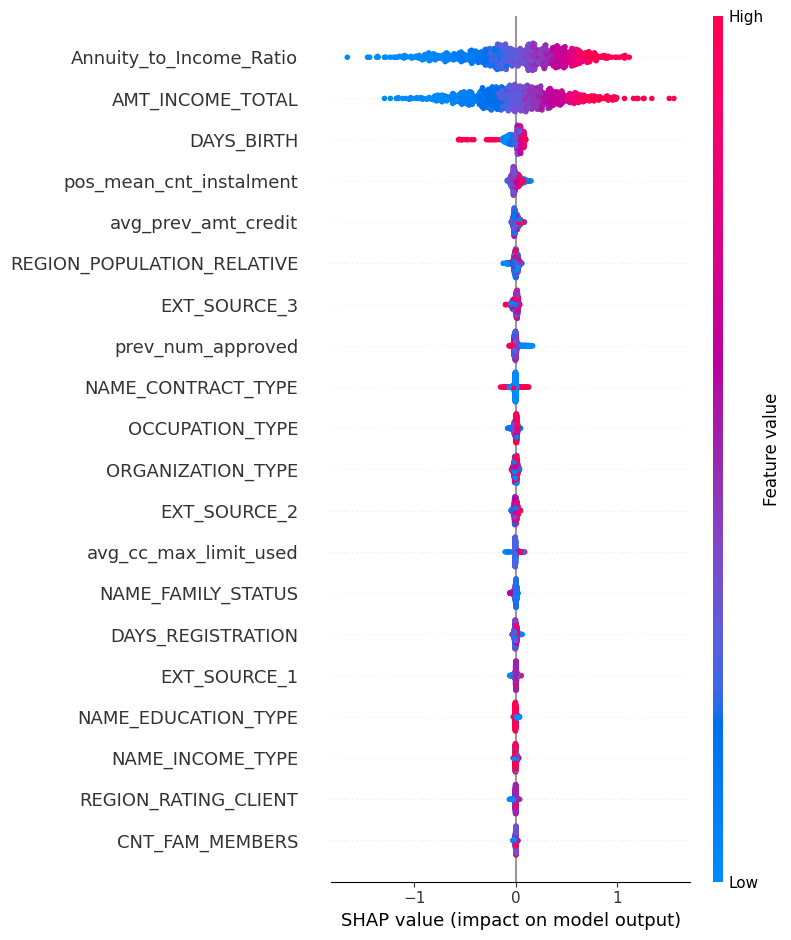

In [154]:
X_shap = X_val.sample(1000, random_state=42)
explainer = shap.TreeExplainer(model4)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)

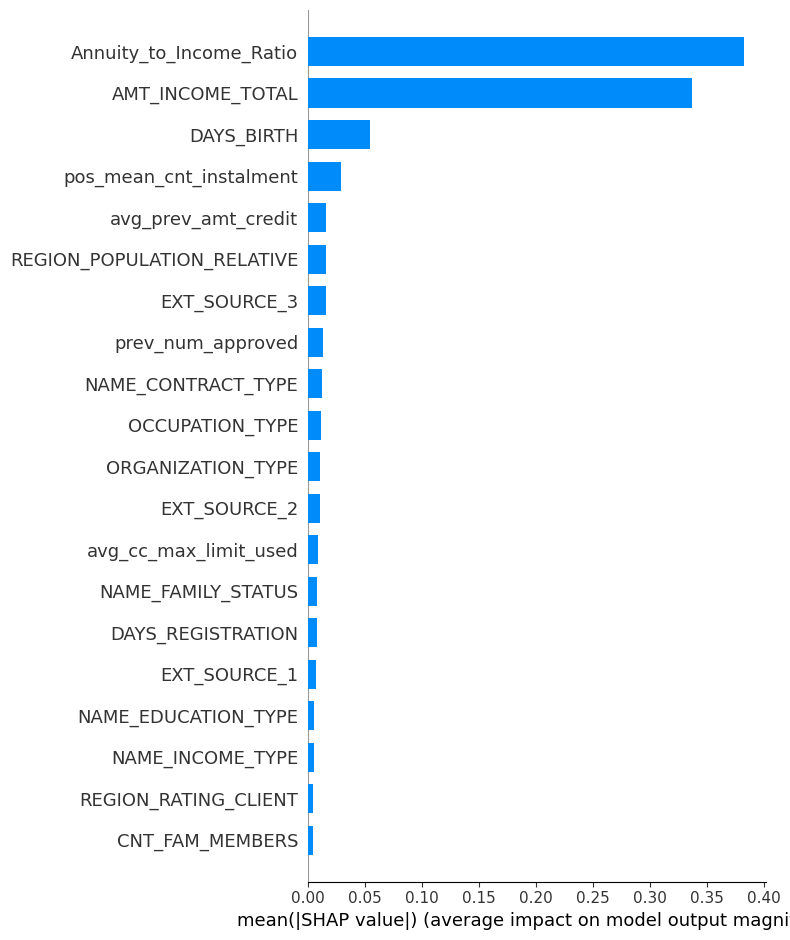

In [155]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

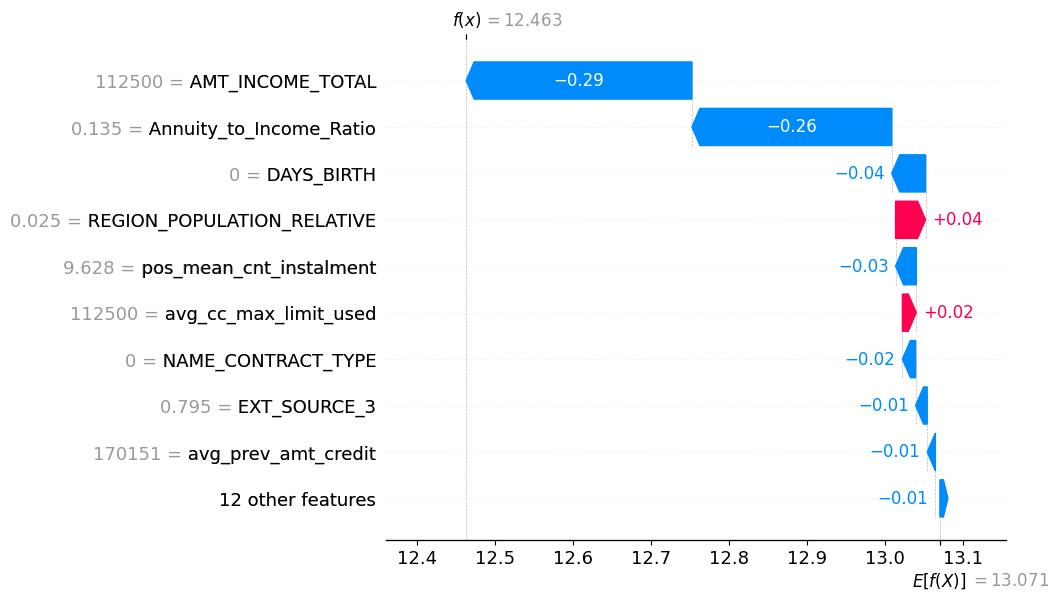

In [156]:
i =901
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_shap.iloc[i],
        feature_names=X_shap.columns
    )
)


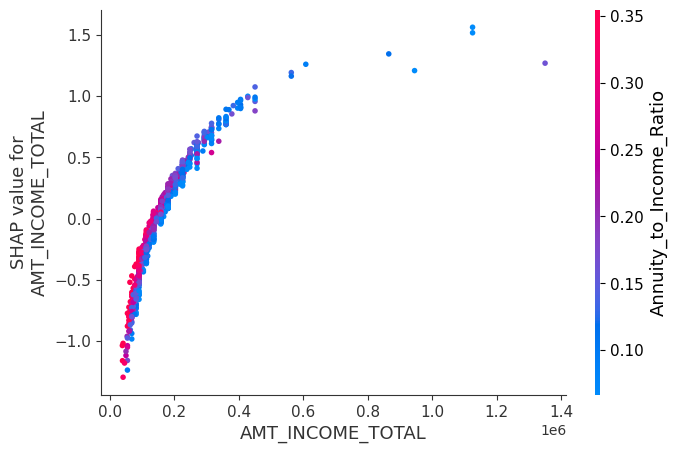

In [157]:
shap.dependence_plot(
    "AMT_INCOME_TOTAL",
    shap_values,
    X_shap
)

In [159]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    model4.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )

    y_pred = model4.predict(X_val)
    fold_mae = mean_absolute_error(
        np.expm1(y_val), np.expm1(y_pred)
    )

    mae_scores.append(fold_mae)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2511
[LightGBM] [Info] Number of data points in the train set: 256259, number of used features: 21
[LightGBM] [Info] Start training from score 13.070113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 256259, number of used features: 21
[LightGBM] [Info] Start training from score 13.070307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

In [160]:
for fold, score in enumerate(mae_scores):
    print(f"Fold {fold+1} MAE: {score:.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Standard Deviation of MAE: {np.std(mae_scores)}")

Fold 1 MAE: 160314.40
Fold 2 MAE: 161451.67
Fold 3 MAE: 160380.70
Fold 4 MAE: 160528.71
Fold 5 MAE: 161545.13
Fold 6 MAE: 161176.19
Average MAE: 160899.47
Standard Deviation of MAE: 507.81680930099895
